In [2]:
import pandas as pd
import numpy as np
import gensim
import ast
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
movie=pd.read_csv('CleanedMovies.csv')
movie['review']=movie['review'].apply(ast.literal_eval)

In [23]:
review=movie['review']

In [24]:
#building vocab using gensim
model=gensim.models.Word2Vec(
    window=20,
    min_count=2,
    workers=10,
    vector_size=150,
    alpha=0.02
)
model.build_vocab(review,progress_per=1000)
print(model)

Word2Vec<vocab=75179, vector_size=150, alpha=0.02>


In [25]:
#training the word2vec model
model.train(
    review,
    total_examples=model.corpus_count,
    epochs=8
)

(44664626, 47910896)

In [26]:
#checking on a random word to find similarity
model.wv.most_similar('cult')

[('poltergeist', 0.6728139519691467),
 ('satanic', 0.626892626285553),
 ('subgenre', 0.605391800403595),
 ('spawned', 0.59166419506073),
 ('tobe', 0.5714994668960571),
 ('exorcist', 0.5655491948127747),
 ('1978', 0.5603047013282776),
 ('troma', 0.5588265061378479),
 ('massacre', 0.5577980875968933),
 ('drivein', 0.5524373650550842)]

In [27]:
model.save('models/w2v/gensimW2V.keras')

In [28]:
vsize=model.wv.vector_size
print(vsize)
# takes a sentence as input and computes the average word vector for the sentence using the Word2Vec model. 
# If a word in the sentence is found in the Word2Vec model's vocabulary, its corresponding word vector is added to the result returning the average word vector
def sent_vec(sent):
    vector_size=model.wv.vector_size
    wv_res=np.zeros(vector_size)
    ctr=1
    for w in sent:
        if w in model.wv:
            ctr+=1
            wv_res+=model.wv[w]
    wv_res=wv_res/ctr
    return wv_res
            

150


In [29]:
movie['vector']=movie['review'].apply(sent_vec)
movie.head()

,review,sentiment,vector
0,"[one, reviewer, mentioned, watching, 1, oz, ep...",1,"[0.7625184839223904, -0.6332674793147269, 0.14..."
1,"[wonderful, little, production, filming, techn...",1,"[0.016645319725772958, -0.1781475378850634, 0...."
2,"[thought, wonderful, way, spend, time, hot, su...",1,"[0.6559302829923215, 0.09279947309358709, -0.0..."
3,"[basically, there, family, little, boy, jake, ...",0,"[0.5677479506950035, -0.04456447317462527, 0.0..."
4,"[petter, matteis, love, time, money, visually,...",1,"[0.8746408372506743, -0.27860030810325787, 0.1..."


In [30]:
X=np.array(movie['vector'].to_list())
y=np.array(movie['sentiment'].to_list())
#Train-test split at 0.2 and randomstate as 2023
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

In [31]:
#choosing the validation subset from training set
validation_size = 0.1
num_samples = len(X_train)
val_size = int(validation_size * num_samples)

val_indices = np.random.choice(num_samples, val_size, replace=False)

X_val = X_train[val_indices]
y_val = y_train[val_indices]

X_train = np.delete(X_train, val_indices, axis=0)
y_train = np.delete(y_train, val_indices, axis=0)

In [32]:
#creating TensorFlow Dataset objects from the training, validation, and test data . 
# It shuffles the training data and batches all datasets with a batch size of 60. Additionally, 
# it prefetches elements from the datasets to improve performance by overlapping the data preprocessing and model execution. 
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

batch_size = 60
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

print("Train dataset shape:", train_dataset.element_spec)
print("Validation dataset shape:", val_dataset.element_spec)
print("Test dataset shape:", test_dataset.element_spec)

Train dataset shape: (TensorSpec(shape=(None, 150), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Validation dataset shape: (TensorSpec(shape=(None, 150), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Test dataset shape: (TensorSpec(shape=(None, 150), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


In [33]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers.schedules import ExponentialDecay

#The initial learning rate is set to 0.001, and it decays exponentially with a decay rate of 0.9 every 1000 steps
ilr = 0.001
ilr_opte = ExponentialDecay(
    ilr,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True)

# creating several dense layers with ReLU activation functions, batch normalization layers, and dropout layers for regularization
model = Sequential([
    
    Dense(128, activation='relu', input_shape=(vsize,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=ilr_opte),
              loss='binary_crossentropy',
              metrics=['accuracy'])

C:\Users\rektg\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
#stopping training process if the validation loss does not improve after 15 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit(train_dataset,
                    epochs=150,
                    validation_data=val_dataset,
                    callbacks=[early_stopping]
                    )


Epoch 1/150
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7804 - loss: 0.4570 - val_accuracy: 0.8715 - val_loss: 0.3030
Epoch 2/150
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8630 - loss: 0.3266 - val_accuracy: 0.8750 - val_loss: 0.3009
Epoch 3/150
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8707 - loss: 0.3121 - val_accuracy: 0.8780 - val_loss: 0.2953
Epoch 4/150
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8666 - loss: 0.3179 - val_accuracy: 0.8745 - val_loss: 0.2947
Epoch 5/150
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8733 - loss: 0.3039 - val_accuracy: 0.8737 - val_loss: 0.2944
Epoch 6/150
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8731 - loss: 0.3061 - val_accuracy: 0.8765 - val_loss: 0.2927
Epoch 7/150
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8773 - loss: 0.2980 - val_accuracy: 0.8795 - val_loss: 0.2898
Epoch 8/150
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8772 - loss: 0.2975 - val_accu

In [35]:
#converting predicted probabilities into binary predictions y_pred_binary by considering any probability greater than 0.5 as class 1 and less than or equal to 0.5 as class 0
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
accuracy=np.sum(y_test.reshape(len(y_test),1)==y_pred_binary)*100/len(y_test)
accuracy

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step


88.73

In [36]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │        19,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,884 (355.02 KB)

 Trainable params: 30,145 (117.75 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 60,291 (235.52 KB)

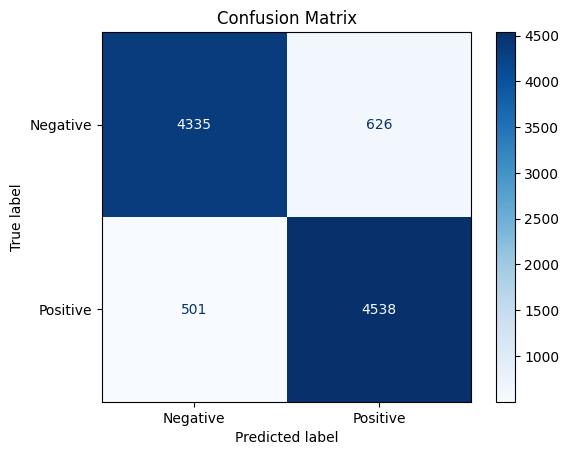

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_binary)
labels = ['Negative', 'Positive']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

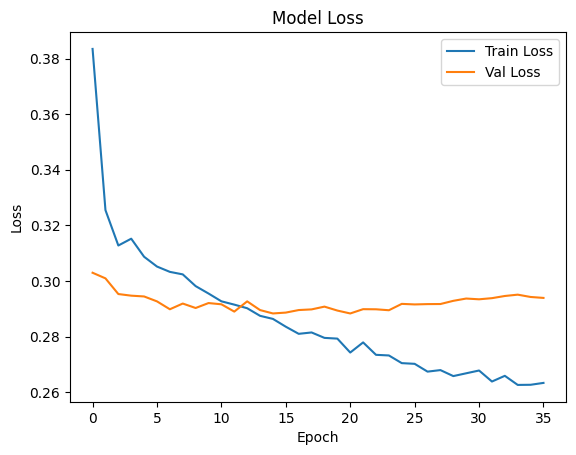

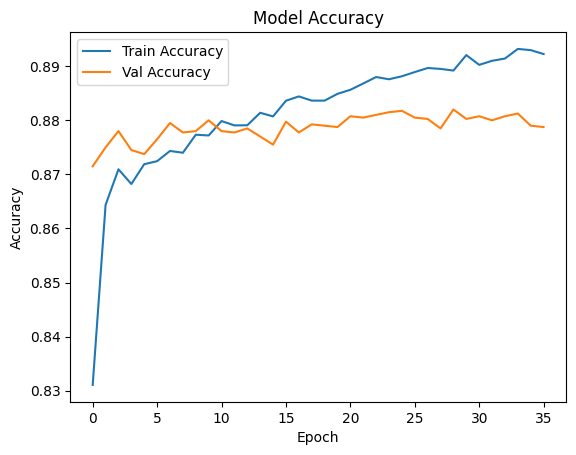

In [38]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [39]:
model.save('models/w2v/w2v.keras')
model.save_weights('models/w2v/w2v.weights.h5')

In [3]:
model=keras.saving.load_model('models/w2v/w2v.keras')
model.summary()
print(model.count_params())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │        19,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,884 (355.02 KB)

 Trainable params: 30,145 (117.75 KB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 60,291 (235.52 KB)

30593
